# Benchmarking Code Optimizations

In [1]:
from jewels import *
from benchmark import BenchmarkSpace

## Algorithm Benchmark space

In [2]:
algo_space = BenchmarkSpace(nb_boxes = 999)
algo_space.with_nb_queries([250, 500, 750, 1000])\
          .with_queries_length([50, 100, 200, 300, 400, 500])\
          .with_strategies(['Naive', 'SumBuiltin', 'NaiveSlicing', 'SumSlicing', 'OneLiner'])

|boxes|        = 999
|strategies|   = 5 (Naive, SumBuiltin, NaiveSlicing, SumSlicing, OneLiner)
|query_length| = 6 (50, 100, 200, 300, 400, 500)
|nb_queries|   = 4 (250, 500, 750, 1000)
==>> |space|   = 120

In [3]:
nb_processes = 20
nb_runs = 3
print(f'number of experiments (without warmups) {120* nb_processes * nb_runs}')

number of experiments (without warmups) 7200


## Pythonic optimizations

In [4]:
available_strategies = [Naive(), SumBuiltin(), NaiveSlicing(), SumSlicing(), OneLiner()]

### Reading PyPerf Measurements

In [5]:
from pyperf import BenchmarkSuite
from os.path import exists

In [6]:
bench_datafile = 'outputs/pyperf_measurements.json'
if not exists(bench_datafile):
    raise UserWarning('You must execute the benchmark before exploring the results!')

In [7]:
def extract_benchmark_algos(file: str) -> set[str]:
    suite = BenchmarkSuite.load(file)
    context = suite.get_benchmark_names()
    return set(map(lambda c: c.split('-')[0], context))

In [8]:
extract_benchmark_algos(bench_datafile)

{'Cached', 'Naive', 'NaiveSlicing', 'OneLiner', 'SumBuiltin', 'SumSlicing'}

#### Extracting observations from PyPerf data format

In [9]:
import numpy as np           ## Used to compute percentiles
from scipy.stats import iqr  ## used to compute IQR value

In [10]:
Context = tuple[str, str, str, str]        ## (name, |boxes|, |nb_queries|, |query_length|)
Observations = dict[Context, list[float]]  ## Bind Contexts to Observations 

In [11]:
def remove_outliers(observed: list[float]) -> list[float]:
    """Remove outliers using the IQR (inter-quartile range) method"""
    iqr_factor = 1.5
    q1, q3 = np.percentile(observed, [25, 75], method='midpoint')
    iqr_value = iqr(observed)
    lower = q1 - (iqr_factor * iqr_value)
    upper = q3 + (iqr_factor * iqr_value)
    return [obs for obs in observed if (obs >= lower and obs <= upper)]

In [12]:
def extract_observations(bench_file: str, keep_outliers: bool = False) -> Observations:
    suite = BenchmarkSuite.load(bench_file)
    result = {}
    for bench in suite.get_benchmarks():
        context = tuple(bench.get_name().split('-'))
        observations = list(bench.get_values())
        if keep_outliers:
            result[context] = observations
        else:
            result[context] = remove_outliers(observations)
    return result

In [13]:
def count_observations(obs: Observations) -> int:
    return len(list(np.concatenate(list(obs.values())).flat))

In [14]:
obs_complete = extract_observations(bench_datafile, keep_outliers = True)
obs = extract_observations(bench_datafile)

In [15]:
kept_percent = count_observations(obs) / count_observations(obs_complete)
print(f'|obs_complete| = {count_observations(obs_complete)}')
print(f'|obs|          = {count_observations(obs)} ({kept_percent:.2%})')

|obs_complete| = 8640
|obs|          = 8125 (94.04%)


### Graphing Execution Time against Nb_Queries

In [16]:
from matplotlib import pyplot as plt
from statistics import mean

In [17]:
def prettyfy_plot(fig, axes, w: int, h: int):
    for ax in axes.flat:
        ax.label_outer()
    fig.set_size_inches(w, h)
    fig.tight_layout()

In [18]:
def plot_time_against_nb_queries(obs: Observations, nb_queries: list[int], algorithms: list[str], boxes: int, length: int, canvas):
    observed = { k: mean(o) * 1000 for k, o in obs.items() } ## We are plotting the avg execution time in ms
    x_series = nb_queries
    for algo in algorithms:
        # Extracting the y values associated to the x series
        y_series = list(map(lambda e: observed[(algo, str(boxes), str(e), str(length))], nb_queries))
        canvas.plot(x_series, y_series, label = algo, linestyle='--', marker='o')
    canvas.set_title(f'query_length={length}')
    canvas.set(xlabel='|queries|', ylabel='avg time(ms)')
    canvas.legend()

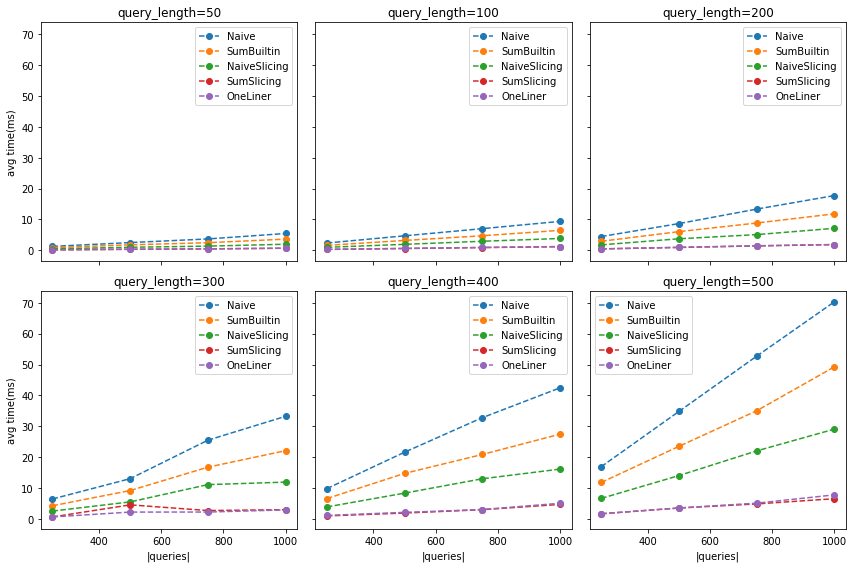

In [19]:
from itertools import product
nb_boxes   = 999
nb_queries = [250, 500, 750, 1000]
strats     = ['Naive', 'SumBuiltin', 'NaiveSlicing', 'SumSlicing', 'OneLiner']
lengths    = [50, 100, 200, 300, 400, 500]

fig, axes = plt.subplots(2,3, sharex = True, sharey=True)
for x,y in product(range(2), range(3)):  # [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
    idx = x * 3 + y  # plot (1,1) depicts the 4th length (query_length=400)
    plot_time_against_nb_queries(obs, nb_queries, strats, nb_boxes, lengths[idx], axes[x,y])
    
prettyfy_plot(fig, axes, w = 12, h = 8)

### Graphing Execution Time against Query Lengths

In [20]:
def plot_time_against_query_lengths(obs: Observations, lengths: list[int], algorithms: list[str], boxes: int, nb_queries: int, canvas):
    observed = { k: mean(o) * 1000 for k, o in obs.items() } ## We are plotting the avg execution time in ms
    x_series = lengths
    for algo in algorithms:
        # Extracting the y values associated to the x series
        y_series = list(map(lambda e: observed[(algo, str(boxes), str(nb_queries), str(e))], lengths))
        canvas.plot(x_series, y_series, label = algo, linestyle='--', marker='o')
    canvas.set_title(f'|queries|={nb_queries}')
    canvas.set(xlabel='length', ylabel='avg time(ms)')
    canvas.legend()

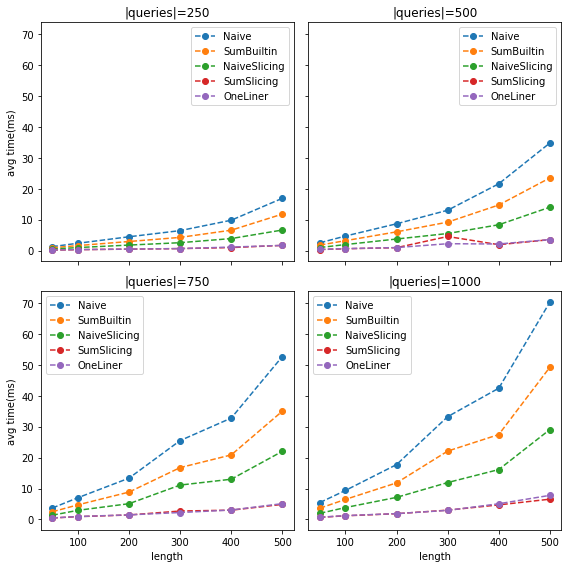

In [21]:
nb_boxes   = 999
nb_queries = [250, 500, 750, 1000]
strats     = ['Naive', 'SumBuiltin', 'NaiveSlicing', 'SumSlicing', 'OneLiner']
lengths    = [50, 100, 200, 300, 400, 500]

fig, axes = plt.subplots(2,2, sharex = True, sharey=True)
for x,y in product(range(2), range(2)): 
    idx = x * 2 + y 
    plot_time_against_query_lengths(obs, lengths, strats, nb_boxes, nb_queries[idx], axes[x,y])

prettyfy_plot(fig, axes, w = 8, h = 8)

### Observing execution time distribution against query length

In [22]:
def plot_time_distribution(obs: Observations, algo: str, lengths: list[int], boxes: int,  nb_queries: int, canvas):
    sorted(lengths)
    values = list(map(lambda l: obs[(algo, str(boxes), str(nb_queries), str(l))], lengths))
    canvas.boxplot(values, notch=True, labels=lengths)
    canvas.set_title(f'{algo}-{boxes}-{nb_queries}')
    canvas.set(xlabel='length', ylabel='avg time(ms)')

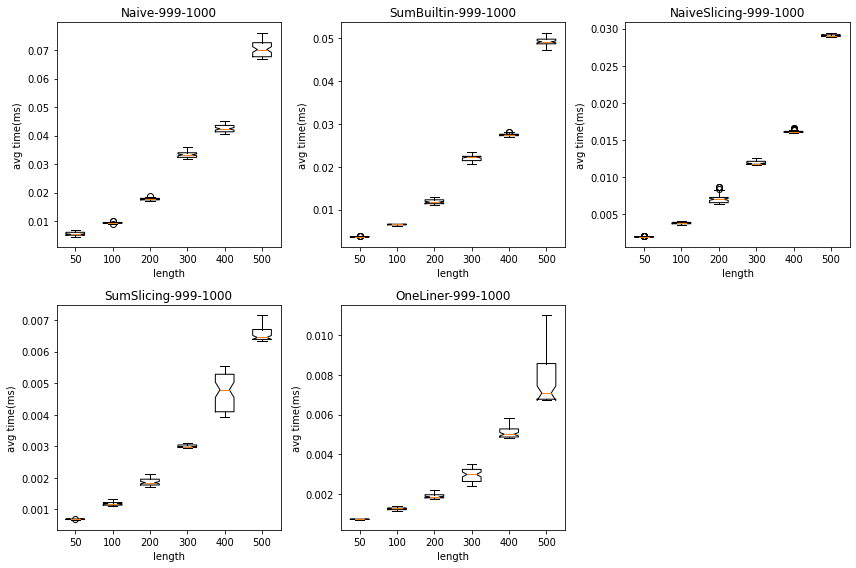

In [23]:
strats     = ['Naive', 'SumBuiltin', 'NaiveSlicing', 'SumSlicing', 'OneLiner']
lengths    = [50, 100, 200, 300, 400, 500]

fig, axes = plt.subplots(2,3)
for x,y in product(range(2), range(3)): 
    idx = x * 3 + y 
    if idx < len(strats):
        plot_time_distribution(obs,  strats[idx], lengths, 999, 1000, axes[x,y])
    else:
        fig.delaxes(axes[x,y])  ## Deleting unnecessary plots
    
fig.set_size_inches(12, 8)
fig.tight_layout()

## Domain optimization: Caching intermediate sums

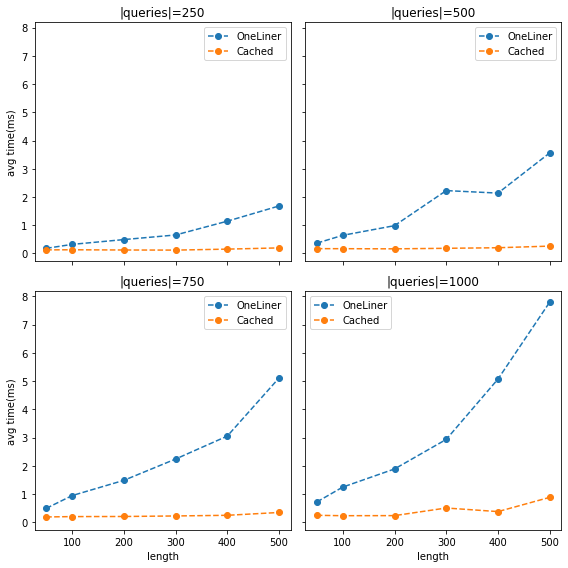

In [24]:
nb_boxes   = 999
nb_queries = [250, 500, 750, 1000]
strats     = ['OneLiner', 'Cached']
lengths    = [50, 100, 200, 300, 400, 500]

fig, axes = plt.subplots(2,2, sharex = True, sharey=True)
for x,y in product(range(2), range(2)): 
    idx = x * 2 + y 
    plot_time_against_query_lengths(obs, lengths, strats, nb_boxes, nb_queries[idx], axes[x,y])
    
prettyfy_plot(fig, axes, w = 8, h = 8)

## Data parallelization: Using multiple CPUs

In [25]:
bench_par_file = 'outputs/pyperf_measurements_par.json'
if not exists(bench_par_file):
    raise UserWarning('You must execute the parallel benchmark before exploring the results!')
obs_par = extract_observations(bench_par_file)

In [26]:
nb_boxes = 999
nb_queries = 5000
query_lengths = [50, 100, 200, 300, 400]
par_strats = [
    'PooledNaive_1', 'PooledNaive_2', 'PooledNaive_3', 'PooledNaive_4', 
    'PooledNaive_5', 'PooledNaive_6', 'PooledNaive_7', 'PooledNaive_8'
]
baselines = ['Cached', 'Naive']

### Plotting execution time over #cpus

In [27]:
def plot_time_against_cpus(obs: Observations, name: str, cpus: list[str], baseline: str, 
                           boxes: int, nb_queries: int, length: int, canvas):
    observed = { k: mean(o) * 1000 for k, o in obs.items() } ## We are plotting the avg execution time in ms
    x_series = cpus
    ## Plotting the parallel measurements
    y_series = list(map(lambda cpu: observed[(f'{name}_{cpu}', str(boxes), str(nb_queries), str(length))], cpus))
    canvas.plot(x_series, y_series, label = name, linestyle='-', marker='o')
    ## Plotting the baselines
    base = observed[(baseline, str(boxes), str(nb_queries), str(length))]
    canvas.plot(x_series, [base]*len(x_series), label = f'baseline ({baseline})', linestyle='-.')
    canvas.set_title(f'|queries|={nb_queries}, length={length}')
    canvas.set(xlabel='|cpus|', ylabel='avg time(ms)')
    canvas.legend()

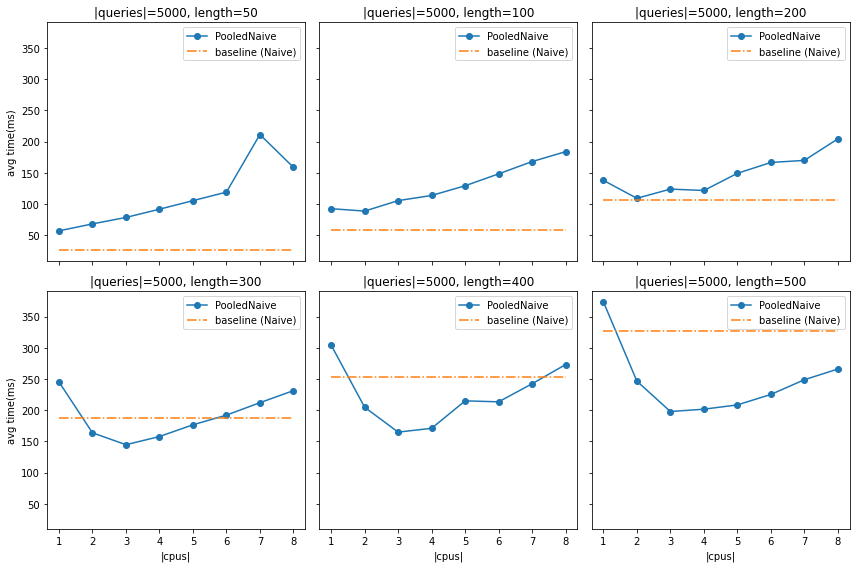

In [28]:
query_lengths = [50, 100, 200, 300, 400, 500]
cpus = [1, 2, 3, 4, 5, 6, 7, 8]

fig, axes = plt.subplots(2,3, sharex = True, sharey=True)
for x,y in product(range(2), range(3)): 
    idx = x * 3 + y 
    if idx < len(query_lengths):
        plot_time_against_cpus(obs_par, 'PooledNaive', cpus, 
                               'Naive', 999, 5000, query_lengths[idx], axes[x,y])
    else:
        fig.delaxes(axes[x,y])  ## Deleting unnecessary plots
    
prettyfy_plot(fig, axes, w = 12, h = 8)

## Plotting execution time over #cpus

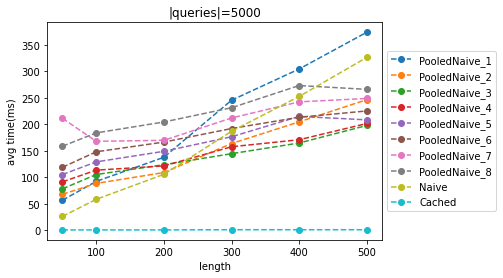

In [29]:
nb_boxes   = 999
strats     = [
    'PooledNaive_1', 'PooledNaive_2', 'PooledNaive_3', 'PooledNaive_4', 
    'PooledNaive_5', 'PooledNaive_6', 'PooledNaive_7', 'PooledNaive_8',
    'Naive', 'Cached']
lengths    = [50, 100, 200, 300, 400, 500]

fig, axe = plt.subplots()
plot_time_against_query_lengths(obs_par, lengths, strats, nb_boxes, 5000, axe)
axe.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legen outside of the plot


### Object Wrapper cost

In [30]:
def plot_time_comp_against_cpus(obs: Observations, names: list[str], cpus: list[str],
                           boxes: int, nb_queries: int, length: int, canvas):
    observed = { k: mean(o) * 1000 for k, o in obs.items() } ## We are plotting the avg execution time in ms
    x_series = cpus
    ## Plotting the parallel measurements
    for name in names:
        y_series = list(map(lambda cpu: observed[(f'{name}_{cpu}', str(boxes), str(nb_queries), str(length))], cpus))
        canvas.plot(x_series, y_series, label = name, linestyle='--', marker='o')
    ## Plotting the baselines
    canvas.set_title(f'|queries|={nb_queries}, length={length}')
    canvas.set(xlabel='|cpus|', ylabel='avg time(ms)')
    canvas.legend()

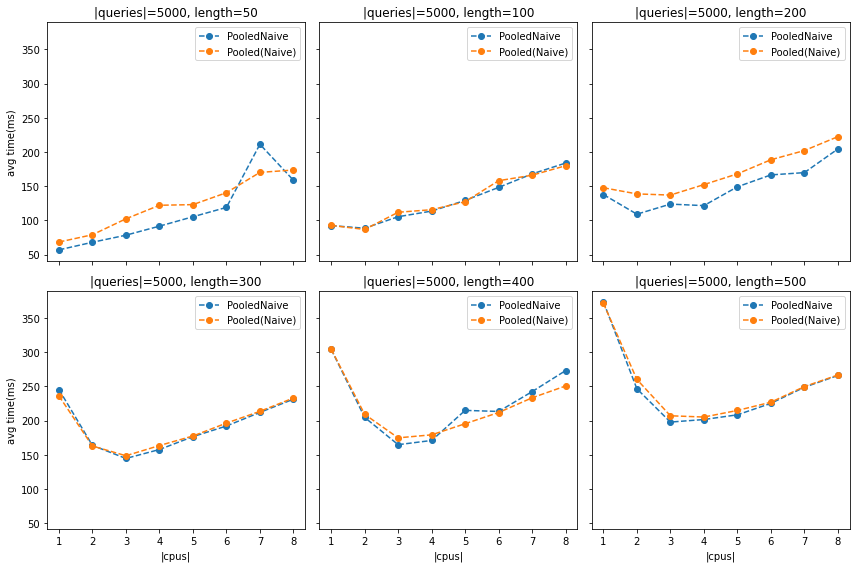

In [31]:
query_lengths = [50, 100, 200, 300, 400, 500]
cpus = [1, 2, 3, 4, 5, 6, 7, 8]

fig, axes = plt.subplots(2,3, sharex = True, sharey=True)
for x,y in product(range(2), range(3)): 
    idx = x * 3 + y 
    if idx < len(query_lengths):
        plot_time_comp_against_cpus(obs_par, ['PooledNaive','Pooled(Naive)'], cpus, 
                               999, 5000, query_lengths[idx], axes[x,y])
    else:
        fig.delaxes(axes[x,y])  ## Deleting unnecessary plots
    
prettyfy_plot(fig, axes, w = 12, h = 8)

## Final benchmark with 3 CPUs

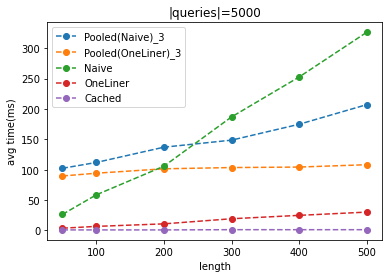

In [32]:
nb_boxes   = 999
strats     = ['Pooled(Naive)_3','Pooled(OneLiner)_3','Naive', 'OneLiner', 'Cached']
lengths    = [50, 100, 200, 300, 400, 500]

fig, axe = plt.subplots()
plot_time_against_query_lengths(obs_par, lengths, strats, nb_boxes, 5000, axe)
axe.legend()